##CS5660 Homework 2
#### Due Date : November 5, 2015
Angel Wong (axw3@cornell.edu), Halil Akin (ha338@cornell.edu)


###I. Aligning Audio Signals – second attempt

You are going to try and improve the audio alignment you got in the previous HW assignment. This time you’ll use other methods for matching a pair of peak maps. You can use the files and the peak maps you got in the previous HW assignment.

####A. Using Line Fitting

You are going to build functions that compute the similarity between two audio files: audio1 and audio2.

####1. Hash table:

In [156]:
import scipy
import scipy.io.wavfile
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
import pylab
import itertools

%matplotlib inline

In [59]:
# Code from last homework to derive peak maps

def stft(x, window_len=4096, window_shift=2048):
    w = scipy.hamming(window_len)
    X = scipy.array([scipy.fft(w*x[i:i+window_len])
        for i in range(0, len(x)-window_len, window_shift)])
    return scipy.absolute(X[:,0:window_len/2])

def findPeaks(X):
    from scipy.ndimage.filters import maximum_filter
    maxima = (X == maximum_filter(X,20))
    peaksArray = zip(np.where(maxima)[0],np.where(maxima)[1])
    return peaksArray

# Plot a list of peaks in the form [(s1, f1), (s2, f2), ...]
def plot_peaks(peak_list):
    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    s_list, f_list = zip(*peak_list)
    matplotlib.pyplot.plot(s_list, f_list, 'bo')
    ymin, ymax = ax.get_ylim()
    matplotlib.pyplot.xlabel('Window index')
    matplotlib.pyplot.ylabel('Transform coefficient')


In [157]:
# reading and running STFT on audio samples from last homework: 1, 2, 3
#   audio sample 8 is the re-recorded version of audio sample 7
rate1, data1 = scipy.io.wavfile.read('1.wav')
rate2, data2 = scipy.io.wavfile.read('2.wav')
rate3, data3 = scipy.io.wavfile.read('3.wav')
rate7, data7 = scipy.io.wavfile.read('7.wav')
rate8, data8 = scipy.io.wavfile.read('8.wav')

if (len(data1.shape) > 1):
    data1 = data1[:,0]
if (len(data2.shape) > 1):
    data2 = data2[:,0]
if (len(data3.shape) > 1):
    data3 = data3[:,0]
if (len(data7.shape) > 1):    
    data7 = data7[:,0]
if (len(data8.shape) > 1):
    data8 = data8[:,0]

x1 = data1[0:10*rate1]
x2 = data2[0:10*rate2]
x3 = data3[0:10*rate3]
x7 = data7[0:10*rate7]
x8 = data8[0:10*rate8]

X1 = stft(x1)
X2 = stft(x2)
X3 = stft(x3)
X7 = stft(x7)
X8 = stft(x8)

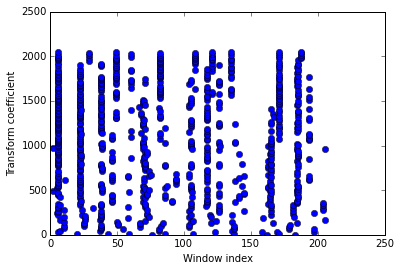

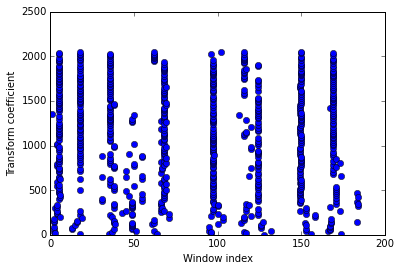

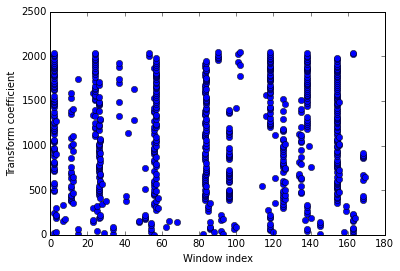

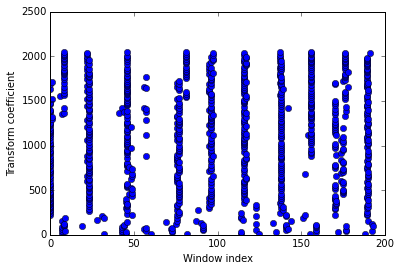

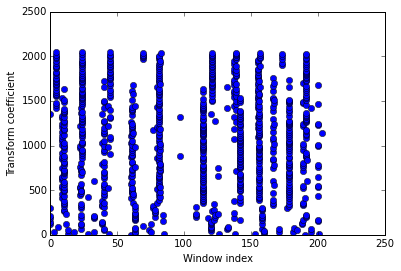

In [61]:
# plot peak maps for audio sample 1, 2, 3, 7 and 8
peaksArray1 = findPeaks(X1)
peaksArray2 = findPeaks(X2)
peaksArray3 = findPeaks(X3)
peaksArray7 = findPeaks(X7)
peaksArray8 = findPeaks(X8)

plot_peaks(peaksArray1)
plot_peaks(peaksArray2)
plot_peaks(peaksArray3)
plot_peaks(peaksArray7)
plot_peaks(peaksArray8)

In [62]:
# N: number of points
# f: frequency gap
# t: time gap

def target_zone_peaks(peak_list, n, time_gap, frequency_gap):

    #  create top_peaks array that stores anchor points (new_peak) and all peaks in
    #  target zone of anchor point (target_zone)
    top_peaks = []
    for new_peak in peak_list:
        
        target_zone = []
        top_peaks.append((new_peak, target_zone))
        
        #  for each existing anchor point in top_peaks, check if the new point should be 
        #  added to this existing anchor point's target zone
        for entry in top_peaks:
            
            # find anchor points time and frequency
            peak_time = entry[0][0]
            peak_freq = entry[0][1]
        
            # define the target zone for each anchor point
            target_zone_x1 = peak_time
            target_zone_x2 = peak_time + time_gap
            target_zone_y1 = peak_freq - (frequency_gap/2)
            target_zone_y2 = peak_freq + (frequency_gap/2)
            
            target_zone_path = mplPath.Path(np.array([[target_zone_x1, target_zone_y1],
                     [target_zone_x1, target_zone_y2],
                     [target_zone_x2, target_zone_y1],
                     [target_zone_x2, target_zone_y2]]))
            
            #  check if target zone contains new point
            if (target_zone_path.contains_point(new_peak)):
                #  n is being arbitrarily selected as the first n peaks
                #  should this be calculated through euclidean distance
                if (len(entry[1]) <= n):
                    entry[1].append(new_peak)

    return top_peaks
        

In [63]:
def top_n_peaks(peaks, n):
    print len(peaks[1])
    if (len(peaks[1]) <= n):
        print "no problem here"
    else:
        peaks_dist = scipy.spatial.distance.cdist([peaks[0]], peaks[1], 'euclidean')
        print peaks_dist

In [64]:
# find the "anchor point"-to-"target zone peaks" array for each audio file
#  using arbitrary selections of n, f, t
audio1_target_zone_peaks = target_zone_peaks(peaksArray1, 40, 50, 20)
audio2_target_zone_peaks = target_zone_peaks(peaksArray2, 40, 50, 20)
audio3_target_zone_peaks = target_zone_peaks(peaksArray3, 40, 50, 20)
audio7_target_zone_peaks = target_zone_peaks(peaksArray7, 40, 50, 20)
audio8_target_zone_peaks = target_zone_peaks(peaksArray8, 40, 50, 20)

In [65]:
top_n_peaks(audio1_target_zone_peaks[0], 20)

1
no problem here


#### 2. Matching Hash Tables

In [67]:
# linear hash function defined by Ori on Piazza:
#   frequency1 + difference in frequencies + difference in time
def linear_hash_function(main_peak, new_peak):
    
    freq_diff = new_peak[1] - main_peak[1]
    time_diff = new_peak[0] - main_peak[0]
    hash_value = main_peak[1] + freq_diff + time_diff
    return hash_value

In [68]:
# takes the target_zone_peaks array and converts it to a hash-table array
#   for each pair of "anchor point"-to-"peak in the target zone",
#   calculate a hash value and input this value with the associated time of the anchor point
#   as  a new entry in the hash_table
def hash_table(target_zone_peaks):
    hash_table = []
    for zone in target_zone_peaks:
        main_peak = zone[0]
        target_zone = zone[1]
        
        for peak in target_zone:
            hash_value = linear_hash_function(main_peak, peak)
            time1 = main_peak[0]
            
            hash_table.append((time1, hash_value))

    return hash_table

In [69]:
# calculates hash_tables for each audio file
audio1_hash = hash_table(audio1_target_zone_peaks)
audio2_hash = hash_table(audio2_target_zone_peaks)
audio3_hash = hash_table(audio3_target_zone_peaks)
audio7_hash = hash_table(audio7_target_zone_peaks)
audio8_hash = hash_table(audio8_target_zone_peaks)

In [70]:
# compare hash tables for two audio files and 
#    returns hash values that match in each audio file, along with 
#    the set of associated time values from each audio file

# RETURNS: {(<hash_value>), [{<time values from audio file 1}, {time values from audio file 2}]}

def match_hash_tables(hash_table_1, hash_table_2):
    match_hash_times = {}
    
    # convert hash tables to numpy arrays
    np_hash_table_1 = np.array(hash_table_1)
    np_hash_table_2 = np.array(hash_table_2)
    
    # take only hash values from each numpy hash table
    hash_values_1 = [hash_grp[1] for hash_grp in np_hash_table_1]
    hash_values_2 = [hash_grp[1] for hash_grp in np_hash_table_2]
    
    #print len(hash_values_1)
    #print len(set(hash_values_1))

    # find common hash values in both numpy hash tables
    hash_value_matches_bool_1 = np.in1d(hash_values_1, hash_values_2)
    hash_value_matches_bool_2 = np.in1d(hash_values_2, hash_values_1)

    # return only elements from each numpy hash table that have a match
    matched_table_1 = np_hash_table_1[hash_value_matches_bool_1]
    matched_table_2 = np_hash_table_2[hash_value_matches_bool_2]
    
    # matching hash values across both hash tables (2a)
    matched_hash_values = [hash_grp[1] for hash_grp in matched_table_1]
    
    #print len(matched_hash_values)
    #print len(set(matched_hash_values))
    
    # finds the time values for matched hashes in hash tables
    for unique_hash in matched_hash_values:
        match_times_1 = np.where(matched_table_1 == unique_hash)[0]
        match_times_2 = np.where(matched_table_2 == unique_hash)[0]
        match_times_1 = [y_i[0] for y_i in matched_table_1[match_times_1]]
        match_times_2 = [y_i[0] for y_i in matched_table_2[match_times_2]]
        match_hash_times[unique_hash] = [set(match_times_1)]
        match_hash_times[unique_hash].append(set(match_times_2))

    return match_hash_times

In [83]:
# computes matching on hash_tables for (1) pair permutations of audio files 1, 2, 3 
# (2) audio file 1 with itself
# (3) audio file 7 with 8

audio_matches_1_2 = match_hash_tables(audio1_hash, audio2_hash)
audio_matches_1_3 = match_hash_tables(audio1_hash, audio3_hash)
audio_matches_2_3 = match_hash_tables(audio2_hash, audio3_hash)
audio_matches_dummy = match_hash_tables(audio1_hash, audio1_hash)
audio_matches_7_8 = match_hash_tables(audio7_hash, audio8_hash)

In [72]:
# for each hash value, find the 2d pairs of time values between 
# two audio samples that share that hash value
def match_times_2d_pairs(audio_matches):
    time_pairs = []
    for key in audio_matches:
        times = audio_matches.get(key)
        audio1_times = list(times[0])
        audio2_times = list(times[1])
        pairs = list(itertools.product(audio1_times, audio2_times))
        time_pairs.append(pairs)
    time_pairs = sum(time_pairs, [])
    return time_pairs

In [84]:
# computes all the pairs between time values for all the audio pairs in question
time_pairs_1_2 = match_times_2d_pairs(audio_matches_1_2)
time_pairs_1_3 = match_times_2d_pairs(audio_matches_1_3)
time_pairs_2_3 = match_times_2d_pairs(audio_matches_2_3)
time_pairs_dummy = match_times_2d_pairs(audio_matches_dummy)
time_pairs_7_8 = match_times_2d_pairs(audio_matches_7_8)

In [115]:
# plot time pairs of two audio files
def plot_times(time_pairs, title):
    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    s_list, f_list = zip(*time_pairs)
    matplotlib.pyplot.plot(s_list, f_list, 'bo')
    ymin, ymax = ax.get_ylim()
    matplotlib.pyplot.xlabel('Sound File 1')
    matplotlib.pyplot.ylabel('Sound File 2')
    matplotlib.pyplot.title(title)

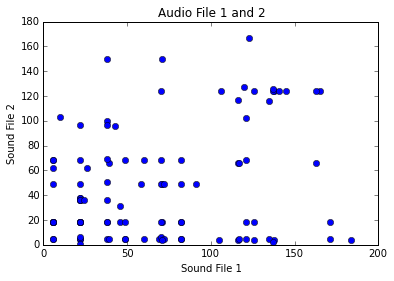

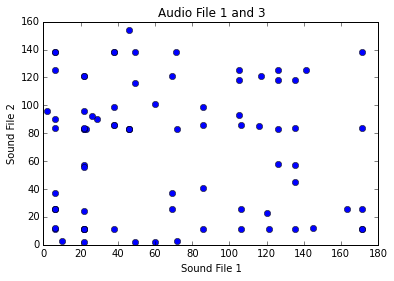

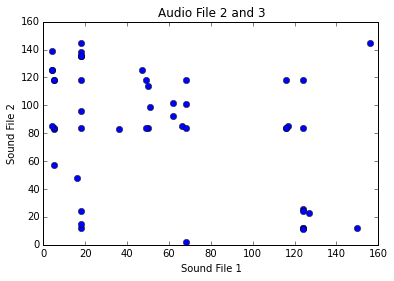

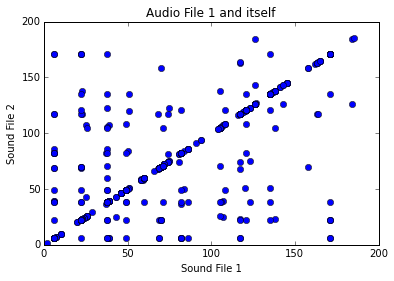

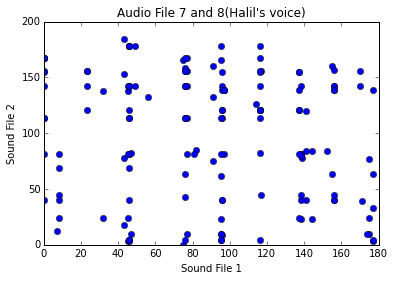

In [152]:
plot_times(time_pairs_1_2, "Audio File 1 and 2")
plot_times(time_pairs_1_3, "Audio File 1 and 3")
plot_times(time_pairs_2_3, "Audio File 2 and 3")
plot_times(time_pairs_dummy, "Audio File 1 and itself")
plot_times(time_pairs_7_8, "Audio File 7 and 8(Halil's voice)")

#### 3. Matching Audio Segments

##### 3a. Hough Transform

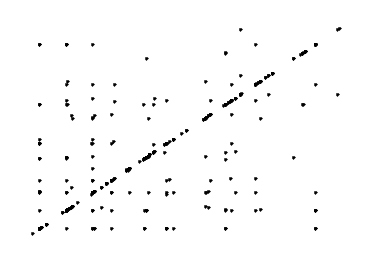

In [99]:
# cleans time pairs scatter plot to remove axes 
def plot_times_img(time_pairs):
    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    s_list, f_list = zip(*time_pairs)
    matplotlib.pyplot.plot(s_list, f_list, 'k.')
    ymin, ymax = ax.get_ylim()
    matplotlib.pyplot.axis('off')
    
plot_times_img(time_pairs_dummy)
matplotlib.pyplot.savefig('time_pairs_1_1.png')

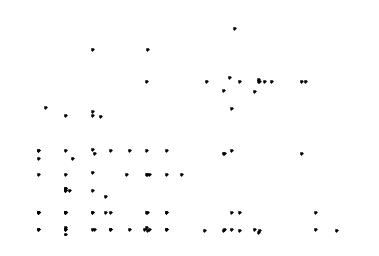

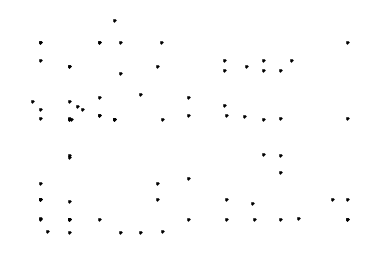

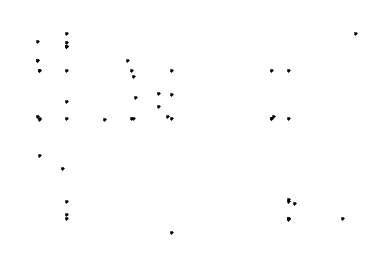

In [136]:
plot_times_img(time_pairs_1_2)
matplotlib.pyplot.savefig('time_pairs_1_2.png')
plot_times_img(time_pairs_1_3)
matplotlib.pyplot.savefig('time_pairs_1_3.png')
plot_times_img(time_pairs_2_3)
matplotlib.pyplot.savefig('time_pairs_2_3.png')

In [141]:
# implementation of Hough from internet:

from math import hypot, pi, cos, sin
from PIL import Image
from matplotlib.pyplot import imshow
 
def hough(im, ntx=460, mry=360):
    "Calculate Hough transform."
    pim = im.load()
    nimx, mimy = im.size
    mry = int(mry/2)*2          #Make sure that this is even
    him = Image.new("L", (ntx, mry), 255)
    phim = him.load()
 
    rmax = hypot(nimx, mimy)
    dr = rmax / (mry/2)
    dth = pi / ntx
 
    for jx in xrange(nimx):
        for iy in xrange(mimy):
            col = pim[jx, iy]
            if col == 255: continue
            for jtx in xrange(ntx):
                th = dth * jtx
                r = jx*cos(th) + iy*sin(th)
                iry = mry/2 + int(r/dr+0.5)
                phim[jtx, iry] -= 1
    return him

def test(image_file):
    "Test Hough transform with pentagon."
    im = Image.open(image_file).convert("L")
    him = hough(im)
    #him.show()
    imshow(np.asarray(him), cmap="Greys_r")
    return him


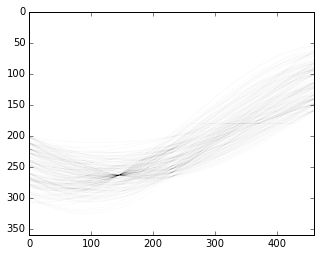

In [142]:
him_1_1 = test("time_pairs_1_1.png")
him_1_1.save("hough_time_pairs_1_1.png")

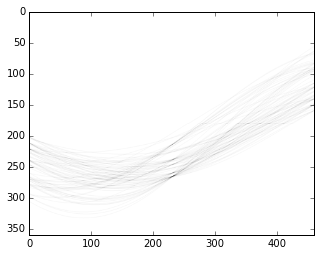

In [143]:
him_1_2 = test("time_pairs_1_2.png")
him_1_2.save("hough_time_pairs_1_2.png")

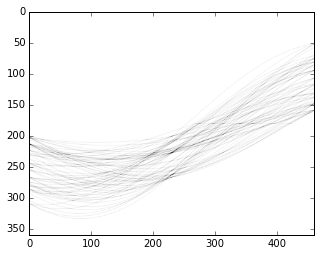

In [144]:
him_1_3 = test("time_pairs_1_3.png")
him_1_3.save("hough_time_pairs_1_3.png")

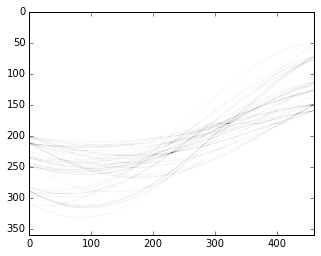

In [145]:
him_2_3 = test("time_pairs_2_3.png")
him_2_3.save("hough_time_pairs_2_3.png")

##### 3b. RANSAC line fitting

In [154]:
# implementation of RANSAC from skimage library

from skimage.measure import LineModel, ransac

def audio_ransac(time_pairs, title):
    model = LineModel()
    
    time_pairs_array = np.asarray(time_pairs)
    model.estimate(time_pairs_array)

    model_robust, inliers = ransac(time_pairs_array, LineModel, min_samples=2, 
                                   residual_threshold=1, max_trials=1000)

    line_x = np.arange(0, 200)
    line_y_robust = model_robust.predict_y(line_x)

    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    s_list, f_list = zip(*time_pairs)
    matplotlib.pyplot.plot(s_list, f_list, 'bo')
    ymin, ymax = ax.get_ylim()
    matplotlib.pyplot.xlabel('Sound File 1')
    matplotlib.pyplot.ylabel('Sound File 2')
    ax.plot(line_x, line_y_robust, '-b', label='RANSAC line model')
    ax.set_ylim(0, 200)
    matplotlib.pyplot.title(title)

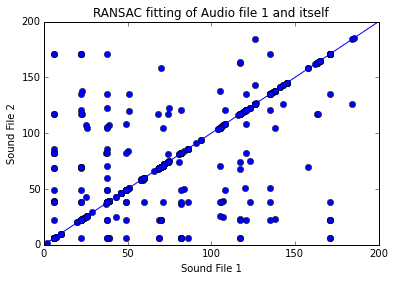

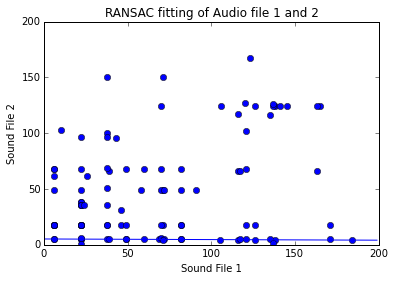

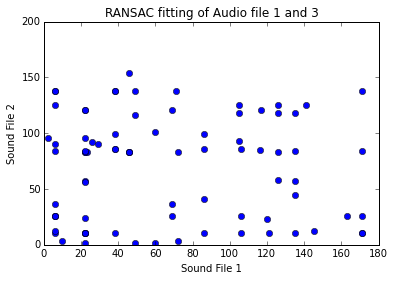

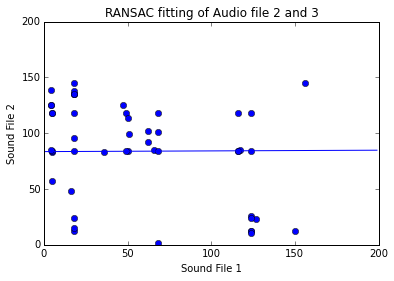

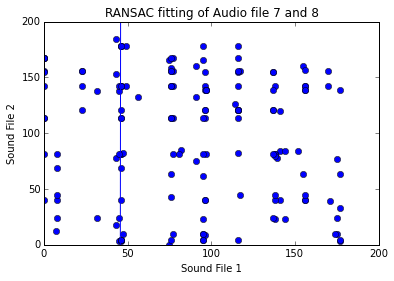

In [155]:
audio_ransac(time_pairs_dummy, "RANSAC fitting of Audio file 1 and itself")
audio_ransac(time_pairs_1_2, "RANSAC fitting of Audio file 1 and 2")
audio_ransac(time_pairs_1_3, "RANSAC fitting of Audio file 1 and 3")
audio_ransac(time_pairs_2_3, "RANSAC fitting of Audio file 2 and 3")
audio_ransac(time_pairs_7_8, "RANSAC fitting of Audio file 7 and 8")